<a href="https://colab.research.google.com/github/BeyzaSalmann/CNN_siniflandirma/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Adınız:** Beyza

**Soyadınız:** Salman

**Okul Numaranız:** 2212721049

**GitHub Repo Bağlantısı:** https://github.com/BeyzaSalmann/CNN_siniflandirma

# 2. Proje Yaklaşımı:Özgün Mimari Tasarımı: Sıfırdan CNN Eğitimi (Model 2)


**Proje Özeti :**

Bu not defterinde, UNO oyun kartları üzerindeki **"Engel" (Skip)** ve **"Yön Değiştir" (Reverse)** sembollerini sınıflandırmak için herhangi bir hazır model (Transfer Learning) kullanmadan, **sıfırdan (from scratch)** bir Evrişimli Sinir Ağı (CNN) mimarisi tasarlanmış ve eğitilmiştir. Amaç, temel bir yapay sinir ağının kısıtlı veri seti üzerindeki öğrenme kapasitesini test etmek ve bir referans noktası (baseline) oluşturmaktır.


**Kullanılan Yöntem ve Mimari:**

* **Mimari Yapısı:** CIFAR-10 gibi klasik görüntü işleme problemlerinde kullanılan temel `Sequential` yapı benimsenmiştir.
* **Katmanlar:** 3 adet **Evrişim Bloğu** (Conv2D + MaxPooling2D) kullanılarak görüntüden öznitelik (kenar, köşe, şekil) çıkarımı yapılmıştır. Filtre sayıları **32 -> 64 -> 128** şeklinde artırılarak modelin basitten karmaşığa doğru öğrenmesi hedeflenmiştir.
* **Veri İşleme:** Bu aşamada, modelin saf performansını görmek amacıyla Veri Artırma (Data Augmentation) uygulanmamış, sadece **0-1 normalizasyon** (rescaling) yapılmıştır.


**Beklenen Sonuç:**

Veri sayısı az olduğu ve hazır ağırlıklar kullanılmadığı için, bu modelin VGG16 (Model 1) veya optimize edilmiş Model 3'e kıyasla daha düşük bir performans göstermesi beklenen bir durumdur.

### 1. Kütüphanelerin Yüklenmesi ve Veri Hazırlığı (Data Preprocessing)

Bu bölümde, modelin eğitimi için gerekli olan temel kütüphaneler (TensorFlow, Keras, NumPy vb.) içe aktarılmış ve Google Drive üzerindeki veri seti çalışma ortamına dahil edilmiştir.

**Yapılan İşlemler:**
1.  **Veri Seti Entegrasyonu:** `zipfile` kütüphanesi kullanılarak, sıkıştırılmış veri seti (`.zip`) Colab ortamına çıkarılmış ve dosya yolları tanımlanmıştır.
2.  **Hiperparametre Ayarları:**
    * **Görüntü Boyutu:** Modelin giriş katmanına uygun olarak `128x128` piksel belirlenmiştir.
    * **Batch Size:** Eğitim sırasında aynı anda işlenecek görsel sayısı `32` olarak ayarlanmıştır.
    * **Epoch:** Model 2 temel bir mimari olduğu için, aşırı öğrenmeyi (overfitting) önlemek amacıyla eğitim süresi **10 epoch** ile sınırlandırılmıştır.
3.  **Veri Ön İşleme (Normalization):**
    * `ImageDataGenerator` kullanılarak piksel değerleri 0-255 aralığından **0-1 aralığına normalize edilmiştir** (`rescale=1./255`). Bu, modelin daha hızlı ve kararlı öğrenmesini sağlar.
    * *Not: Model 2'nin saf performansını ölçmek amacıyla bu aşamada Veri Artırma (Data Augmentation) uygulanmamıştır.*
4.  **Eğitim ve Doğrulama Ayrımı:** Veri seti, modelin başarısını objektif ölçmek için **%80 Eğitim** ve **%20 Doğrulama (Validation)** olarak ikiye ayrılmıştır.

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from google.colab import drive


drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/OdevProjesi/veri_seti.zip"
extract_path = "/content/dataset"
base_dir = os.path.join(extract_path, "veri_seti")

if not os.path.exists(base_dir):
    print("Zip dosyası çıkarılıyor...")
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Veri seti başarıyla çıkarıldı.")
    else:
        print("Hata: Zip dosyası bulunamadı.")
else:
    print("Veri seti kullanıma hazır.")

#Model eğitimi için hiperparametrelerin belirlenmesi
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# 4. Veri Artırma (Data Augmentation)
# Bu ayarlar modelin ezberlemesini önler.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
print(f'Sınıf Etiketleri:{train_generator.class_indices}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Veri seti kullanıma hazır.
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Sınıf Etiketleri:{'engel': 0, 'yon_degistir': 1}


### 2. Özgün CNN Mimarisinin Oluşturulması (Model Architecture)

Bu bölümde, görüntü sınıflandırma problemi için özel olarak tasarlanmış, sıralı (Sequential) bir **Evrişimli Sinir Ağı (CNN)** mimarisi inşa edilmiştir. Model, iki ana bileşenden oluşmaktadır: **Öznitelik Çıkarımı (Feature Extraction)** ve **Sınıflandırma (Classification)**.

**Mimari Detayları:**

1.  **Evrişim Blokları (Öznitelik Çıkarımı):**
    * Model, derinleştikçe karmaşıklaşan özellikleri öğrenebilmek için **3 adet Evrişim Bloğu** içerir.
    * Her blokta bir **`Conv2D`** (Filtreleme) ve bir **`MaxPooling2D`** (Boyut İndirgeme) katmanı bulunur.
    * Filtre sayıları **32 → 64 → 128** şeklinde artırılarak; ilk katmanlarda kenar/köşe gibi basit özelliklerin, derin katmanlarda ise şekil/desen gibi karmaşık özniteliklerin yakalanması hedeflenmiştir.

2.  **Sınıflandırma Katmanları (Classification Head):**
    * **`Flatten`:** Evrişim katmanlarından gelen 3 boyutlu matris verisi, tek boyutlu vektöre dönüştürülür.
    * **`Dense (128)`:** Modelin karar verme kapasitesini oluşturan tam bağlantılı katmandır.
    * **`Dropout (0.5)`:** Eğitim sırasında nöronların %50'si rastgele kapatılarak, modelin eğitim verisini ezberlemesi (**Overfitting**) engellenmiştir.
    * **`Dense (2, Softmax)`:** Çıkış katmanıdır. 2 sınıfımız olduğu için her bir sınıfa ait olasılık değerini üretir.

**Derleme (Compilation):**
Modelin eğitimi için adaptif öğrenme hızı sunan **Adam** optimizasyon algoritması ve çok sınıflı sınıflandırma problemlerinde standart olan **Kategorik Çapraz Entropi (Categorical Crossentropy)** kayıp fonksiyonu kullanılmıştır.

In [ ]:
# Temel CNN Mimarisinin Oluşturulması
model = Sequential()

# 1. Evrişim Bloğu (Öznitelik Çıkarımı - Düşük Seviye Özellikler)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) # Boyut indirgeme

# 2. Evrişim Bloğu (Öznitelik Çıkarımı - Orta Seviye Özellikler)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Evrişim Bloğu (Öznitelik Çıkarımı - Yüksek Seviye Özellikler)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Sınıflandırma Katmanları (Fully Connected Layers)
model.add(Flatten()) # 2D matrisin 1D vektöre dönüştürülmesi
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Modelin Derlenmesi (Compilation)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model mimarisinin özeti
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Modelin Eğitimi (Model Training)

Bu hücrede, derlenen CNN modeli eğitim veri seti ile beslenerek öğrenme süreci (training process) başlatılır.

**Eğitim Süreci Detayları:**
* **`model.fit()`:** Modelin ağırlıklarını (weights) minimize edecek şekilde güncelleyen ana fonksiyondur.
* **Epochs:** Model, tüm eğitim veri setini belirlenen tur sayısı (`EPOCHS`) kadar baştan sona tarayacaktır. Model 2'de ezberlemeyi önlemek için bu sayı düşük tutulmuştur.
* **Doğrulama (Validation):** Her epoch sonunda model, eğitim sırasında hiç görmediği doğrulama veri seti (`validation_generator`) üzerinde test edilir. Bu adım, modelin genelleştirme yeteneğini ölçmek ve **aşırı öğrenme (overfitting)** riskini izlemek için kritiktir.
* **History Nesnesi:** Eğitim süresince elde edilen `accuracy` (doğruluk) ve `loss` (kayıp) metrikleri, bir sonraki aşamada grafik çizdirmek üzere `history` değişkeninde saklanır.

In [ ]:
# Model eğitiminin başlatılması
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4375 - loss: 0.7042 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.4375 - loss: 0.7548 - val_accuracy: 0.5000 - val_loss: 0.6785
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5312 - loss: 0.6733 - val_accuracy: 0.5000 - val_loss: 0.6811
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step - accuracy: 0.5000 - loss: 0.7091 - val_accuracy: 0.5000 - val_loss: 0.6833
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6250 - loss: 0.6580 - val_accuracy: 0.5500 - val_loss: 0.6778
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.6621 - val_accuracy: 0.7500 - val_loss: 0.6756
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6840 - loss: 0.6528 - val_accuracy: 0.5000 - val_loss: 0.6782
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - accuracy: 0.6250 - loss: 0.6459 - val_accuracy: 0.5000 - val_loss: 0.6780
Epoch 9

### 4. Eğitim Sonuçlarının Görselleştirilmesi ve Performans Analizi

Bu bölümde, modelin eğitim süreci boyunca kaydettiği ilerleme `matplotlib` kütüphanesi kullanılarak grafiklere dökülmüş ve modelin nihai başarımı ölçülmüştür.

**Yapılan Analizler:**

1.  **Grafiksel Değerlendirme:**
    * **Doğruluk (Accuracy) Grafiği:** Eğitim ve doğrulama setleri üzerindeki doğruluk oranlarının epoch bazında değişimi incelenmiştir. İki eğrinin birbirine yakın seyretmesi, modelin genelleştirme yeteneğinin iyi olduğunu gösterir.
    * **Kayıp (Loss) Grafiği:** Modelin hata oranının zamanla nasıl azaldığını gösterir. Doğrulama kaybının artmaya başlaması, ezberleme (overfitting) sinyali olarak yorumlanabilir.

2.  **Nihai Test Sonucu:**
    * `model.evaluate()` fonksiyonu kullanılarak, modelin eğitim sırasında görmediği **Doğruluk (Validation)** veri seti üzerindeki son performansı hesaplanmış ve raporlanmıştır. Bu değer, modelin gerçek dünya performansını temsil eder.

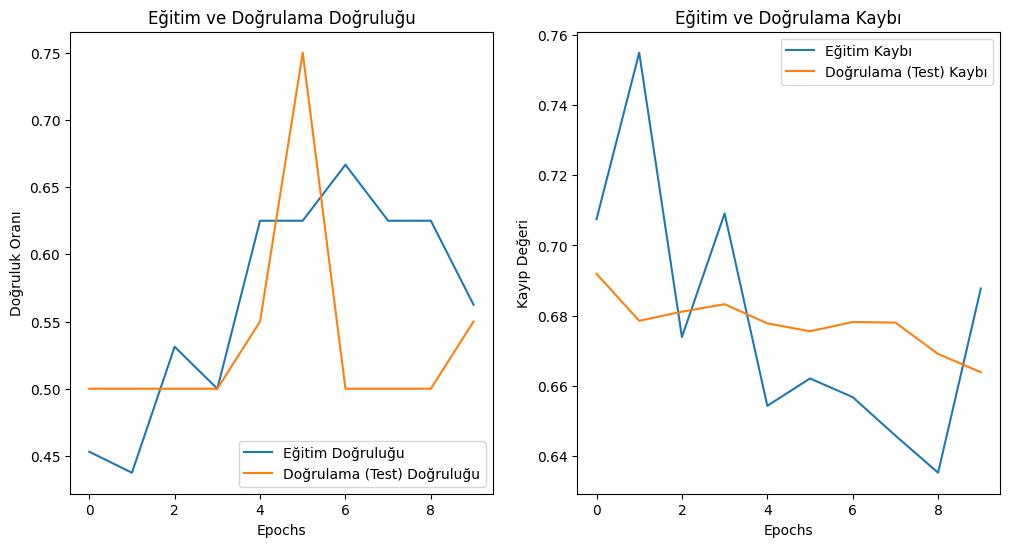

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5500 - loss: 0.6639

Model 2 (Temel CNN) - Test Seti Doğruluğu: %55.00
Model 2 (Temel CNN) - Test Seti Kaybı: 0.6639


In [ ]:
# Eğitim sürecindeki performans metrikleri
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Doğruluk (Accuracy) Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
    plt.plot(epochs_range, val_acc, label='Doğrulama (Test) Doğruluğu')
    plt.legend(loc='lower right')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk Oranı')

    # Kayıp (Loss) Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı')
    plt.plot(epochs_range, val_loss, label='Doğrulama (Test) Kaybı')
    plt.legend(loc='upper right')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.xlabel('Epochs')
    plt.ylabel('Kayıp Değeri')

    plt.show()

# Grafiklerin çizdirilmesi
plot_training_history(history)

val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nModel 2 (Temel CNN) - Test Seti Doğruluğu: %{val_acc * 100:.2f}")
print(f"Model 2 (Temel CNN) - Test Seti Kaybı: {val_loss:.4f}")